In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import nibabel as nib
from surfplot import Plot
from brainspace.mesh import mesh_io, mesh_operations
from neuromaps.datasets import fetch_atlas
import seaborn as sns

from heteromodes.solver import HeteroSolver
from heteromodes.utils import load_hmap, unmask
from heteromodes.plotting import plot_brain

In [2]:
mpl.rcParams['figure.dpi'] = 600

In [3]:
# Load and scale hetero map
parc = "hcpmmp1"
den = "32k"

parc_file = f"{PROJ_DIR}/data/parcellations/parc-{parc}_space-fsLR_den-{den}_hemi-L.label.gii"
parc = nib.load(parc_file).darrays[0].data.astype(int)
medmask = np.where(parc != 0, True, False)

fslr = fetch_atlas('fsLR', den)
# medmask = nib.load(fslr['medial'][0]).darrays[0].data.astype(bool)
# print(len(medmask))

surf = mesh_io.read_surface(str(fslr['midthickness'][0]))
surf_masked = mesh_operations.mask_points(surf, medmask)
nverts = surf_masked.n_points

plot_surf = surf = mesh_io.read_surface(str(fslr['inflated'][0]))

## Calculate homogeneous modes

In [4]:
# calculate homogeneous modes
nmodes = 500
homo_solver = HeteroSolver(surf=surf_masked, hmap=None, alpha=0)
homo_evals, homo_modes = homo_solver.solve(n_modes=nmodes, fix_mode1=True, standardise=True)

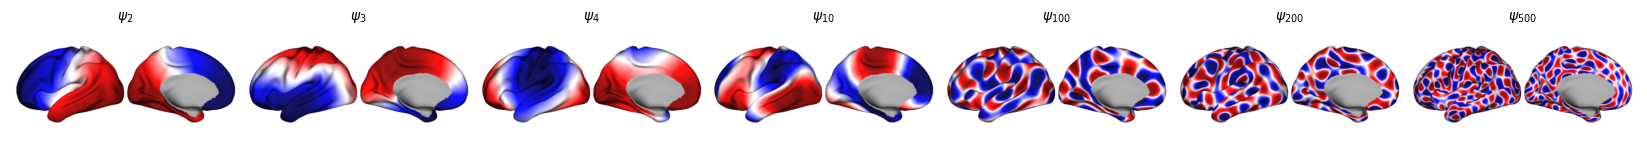

In [5]:
mode_ids = [1, 2, 3, 9, 99, 199, 499]
data = unmask(homo_modes, medmask)[:, mode_ids]
labels = [rf"$\psi_{{{i+1}}}$" for i in mode_ids]

fig = plot_brain(plot_surf, data, labels, cmap="seismic", layout="row", clim_q=[5, 95])
# plt.suptitle("Homogeneous", fontsize=15)
plt.show()

29696
0


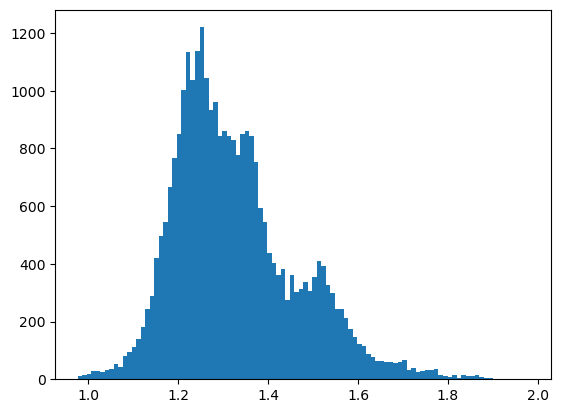

In [6]:
hmap_label = "myelinmap"
hmap = load_hmap(hmap_label, den=den)
hmap = hmap[medmask]
print(np.sum(medmask))
print(np.sum(np.isnan(hmap)))
plt.hist(hmap, bins=100)
plt.show()

## Calculate heterogeneous modes

In [15]:
# Calculate hetero modes
alpha = 1
solver = HeteroSolver(surf=surf_masked, hmap=hmap, alpha=alpha, verbose=True)
print(np.min(solver.rho), np.max(solver.rho))
hetero_evals, hetero_modes = solver.solve(n_modes=nmodes, fix_mode1=True, standardise=True)
hetero_modes = unmask(hetero_modes, medmask)

TriaMesh with anisotropic Laplace-Beltrami
0.07786237 116.81918


1.9129761
3.8689234


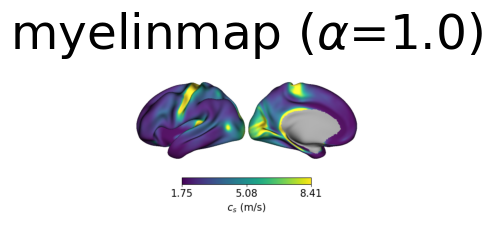

In [16]:
rho = solver.rho
plot_dist = False
plot_cmap = True
print(np.mean(rho))
c = 3.3524 * np.sqrt(rho)
print(np.mean(c))

if plot_dist:
    plt.hist(c, bins=100)
    plt.xlabel("c_s")
if plot_cmap:
    fig = plot_brain(plot_surf, unmask(c, medmask), clim_q=(5, 95), cbar=True, cbar_label="$c_s$ (m/s)", cbar_kws=dict(fontsize=15))
    plt.title(f"{hmap_label} ($\\alpha$={alpha:.1f})", fontsize=35)

plt.show()

In [17]:
np.max(c)

36.23372

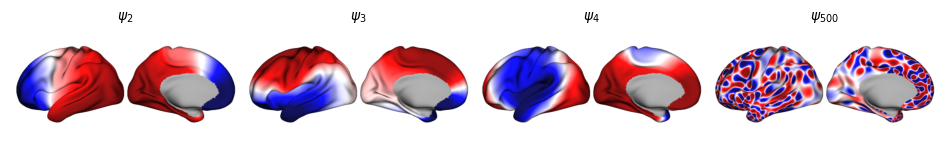

In [18]:
mode_ids = [1, 2, 3, 499]
data = hetero_modes[:, mode_ids]
labels = [rf"$\psi_{{{i+1}}}$" for i in mode_ids]

fig = plot_brain(plot_surf, data, labels, layout="row", cmap="seismic", clim_q=[5, 95])
# plt.suptitle(f"{hmap_label} ($\\alpha$={alpha:.1f})", fontsize=15, y=0.92)
plt.show()

Text(77.92222222222227, 0.5, 'Homogeneous modes')

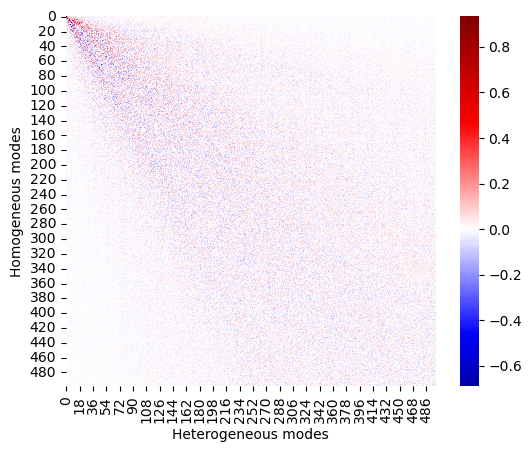

In [19]:
# Plot correlation matrix
corr = np.corrcoef(homo_modes[:, 1:nmodes], hetero_modes[medmask, 1:nmodes], rowvar=False)[:nmodes-1, nmodes-1:]

sns.heatmap(corr, center=0, square=True, cmap="seismic")
plt.gca().set_xlabel("Heterogeneous modes")
plt.gca().set_ylabel("Homogeneous modes")

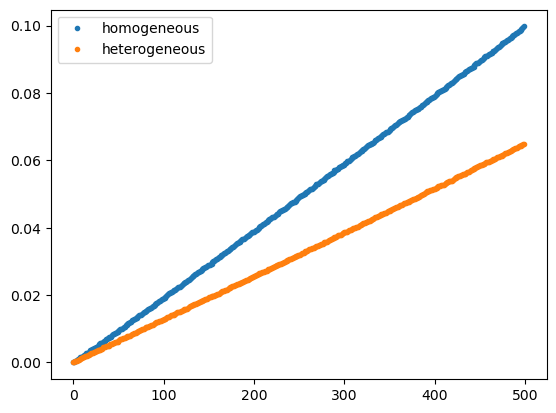

In [20]:
# Plot evals

plt.plot(homo_evals, ".", label="homogeneous")
plt.plot(hetero_evals, ".", label="heterogeneous")
plt.legend()
plt.show()

## Find mode with the highest correlation with the SA axis

Most correlated mode with SA axis: Mode 2 (r = -0.49)


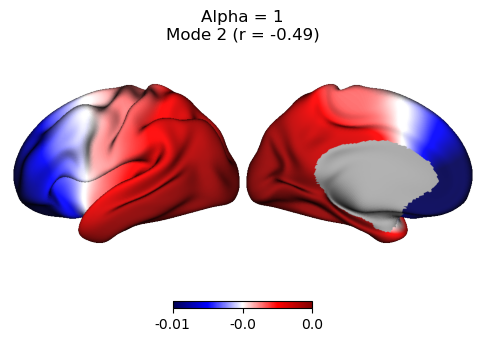

In [21]:
# Show mode with the highest correlation with the SA axis
saaxis = load_hmap("SAaxis", den=den)[medmask]

# correlate each emode with the saaxis
corrs = np.array([np.corrcoef(hetero_modes[medmask, i], saaxis)[0, 1] for i in range(1, nmodes)])
saaxis_mode_id = np.argmax(np.abs(corrs)) + 1
print(f"Most correlated mode with SA axis: Mode {saaxis_mode_id+1} (r = {corrs[saaxis_mode_id-1]:.2f})")

# Plot most correlated mode
data = hetero_modes[:, saaxis_mode_id]
p = Plot(surf_lh=plot_surf, views=["lateral", "medial"], zoom=1.25, size=(500, 250))
color_range = [np.nanpercentile(data, 5), np.nanpercentile(data, 95)]
p.add_layer(hetero_modes[:, saaxis_mode_id], cmap="seismic", color_range=color_range)
fig = p.build()
plt.title(f"Alpha = {alpha}\nMode {saaxis_mode_id+1} (r = {corrs[saaxis_mode_id-1]:.2f})")
plt.show()